c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(4, 128, 64)
0.8800000000000002
False
False
{'speed': 25.500000000000004, 'crashed': False, 'action': [0.5, 0.0], 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 1.0, 'high_speed_reward': np.float64(0.5500000000000004), 'on_road_reward': 1.0}}


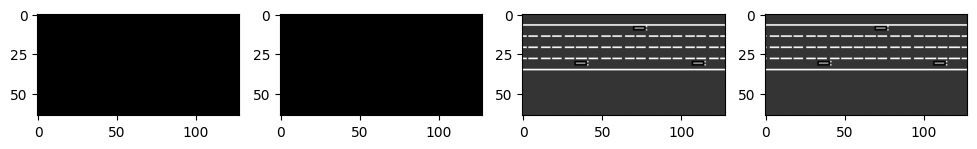

In [1]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import torch

config = {
    "observation": {
        "type": "GrayscaleObservation",
        "observation_shape": (128, 64),
        "stack_size": 4,
        "weights": [0.2989, 0.5870, 0.1140],
        "scaling": 1.75,
    },
    "action": {
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True,
        "steering_range": [-0.15, 0.15],  
        "speed_range": [10, 30]
    },
    "simulation_frequency": 15,
    "policy_frequency": 5, 
    "duration": 40, 
    "offroad_terminal": True,
    "lanes_count": 4,   
}

env = gym.make('highway-fast-v0', config=config, render_mode='rgb_array')
obs, info = env.reset()
action = [0.5, 0.0]

for _ in range(1):
    obs, reward, done, truncated, info = env.step(action)

    print(obs.shape)
    print(reward)
    print(done)
    print(truncated)
    print(info)

    fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

In [2]:
from SAC import SAC

# Create a dummy agent
agent = SAC(env, state_size=4)

# Create a fake input batch: 32 images of size 4x128x64
fake_state = torch.randn(32, 4, 128, 64)
fake_action = torch.randn(32, 2)

# 1. Test Actor
print("Testing Actor...")
mu, log_std = agent.actor(fake_state)
print(f"Actor Output Shape: {mu.shape}") # Should be (32, 2)

# 2. Test Critic
print("Testing Critic...")
# Remember Critic takes (State + Action)
q_val = agent.critic_1(fake_state, fake_action) 
print(f"Critic Output Shape: {q_val.shape}") # Should be (32, 1)

print("Dimensions look good!")

Testing Actor...
Actor Output Shape: torch.Size([32, 2])
Testing Critic...
Critic Output Shape: torch.Size([32, 1])
Dimensions look good!


Step-milestone: 0
Step 7: Episode Reward: 5.43974590553497
Step 14: Episode Reward: 4.775617635409632
Step 25: Episode Reward: 8.316298392021569
Step 31: Episode Reward: 3.960857666206431
Step 46: Episode Reward: 12.050973754909842
Step 55: Episode Reward: 6.558465746092377
Step 70: Episode Reward: 11.514180098396363
Step 79: Episode Reward: 5.894808776835191
Step 96: Episode Reward: 13.420788574040534
Step 120: Episode Reward: 20.744057835206146
Step 125: Episode Reward: 3.4290223969538878
Step 143: Episode Reward: 12.76111747690562
Step 155: Episode Reward: 8.813827639083154
Step 166: Episode Reward: 8.326924221998663
Step 187: Episode Reward: 15.092324874820232
Step 201: Episode Reward: 10.491411143417235
Step 208: Episode Reward: 4.40147360610366
Step 221: Episode Reward: 9.516852614262376
Step 236: Episode Reward: 12.071164004773594
Step 249: Episode Reward: 9.44537059999459
Step 264: Episode Reward: 11.641740812554835
Step 281: Episode Reward: 13.573299856216906
Step 286: Episode

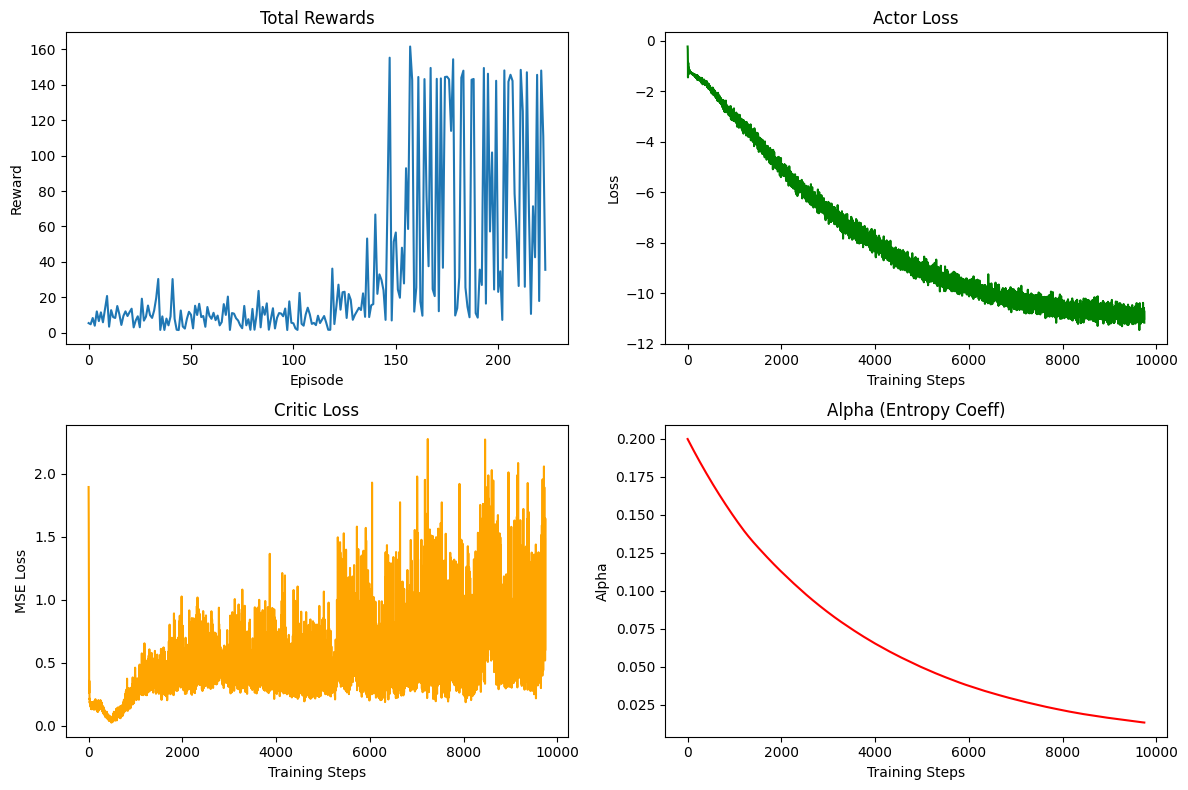

<Figure size 640x480 with 0 Axes>

In [3]:
# Main Loop Test

rewards, critic_losses, actor_losses, alphas = agent.train_loop()

# 2. Visualization (Plotting)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot A: Rewards (Per Episode)
axes[0,0].plot(rewards)
axes[0,0].set_title("Total Rewards")
axes[0,0].set_xlabel("Episode") # Correct
axes[0,0].set_ylabel("Reward")

# Plot B: Critic Loss (Per Step)
axes[1,0].plot(critic_losses, color='orange')
axes[1,0].set_title("Critic Loss")
axes[1,0].set_xlabel("Training Steps") # Changed from Episode
axes[1,0].set_ylabel("MSE Loss")

# Plot C: Actor Loss (Per Step)
axes[0,1].plot(actor_losses, color='green')
axes[0,1].set_title("Actor Loss")
axes[0,1].set_xlabel("Training Steps") # Changed from Episode
axes[0,1].set_ylabel("Loss")

# Plot D: Alpha Decay (Per Step)
axes[1,1].plot(alphas, color='red')
axes[1,1].set_title("Alpha (Entropy Coeff)")
axes[1,1].set_xlabel("Training Steps") # Changed from Episode
axes[1,1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()
plt.savefig("SAC_plots.png")

In [6]:
from gymnasium.wrappers import RecordVideo
eval_env = gym.make('highway-fast-v0', config=config, render_mode='rgb_array')

#agent.load_actor_only("best_model.pth")

eval_env = RecordVideo(
    eval_env, 
    video_folder="videos/sac_highway", 
    episode_trigger=lambda e: True, # Record every episode
    name_prefix="sac_eval"
)

print("Starting Evaluation...")
NUM_EPISODES = 5

for episode in range(NUM_EPISODES):
    obs, info = eval_env.reset()
    done = truncated = False
    score = 0
    
    while not (done or truncated):
        action = agent.choose_action_deterministic(obs)
        next_obs, reward, done, truncated, info = eval_env.step(action)
        obs = next_obs
        score += reward
        
    print(f"Recorded Episode {episode + 1}: Score = {score:.2f}")

eval_env.close()
print("Videos saved to 'videos/sac_highway' folder.")

Starting Evaluation...
Recorded Episode 1: Score = 145.42
Recorded Episode 2: Score = 60.19
Recorded Episode 3: Score = 162.95
Recorded Episode 4: Score = 36.40
Recorded Episode 5: Score = 150.40
Videos saved to 'videos/sac_highway' folder.
